# **Gender classification and landmark detection in celebrity face images**

## **Imports and Setup**

In [124]:
from google.colab import drive
import os
import sys
import importlib

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import seaborn as sns

import albumentations as A
from albumentations.pytorch import ToTensorV2

import random
import time
import copy
import json

In [125]:
# mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Project root
project_root = '/content/drive/MyDrive/finalprojectamlcv'
os.chdir(project_root)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Mounted at /content/drive
Using device: cuda


In [126]:
if project_root not in sys.path:
    sys.path.append(project_root)

import utils
import celebamini

importlib.reload(utils)
importlib.reload(celebamini)

from celebamini import CelebAMini
from utils import *

In [127]:
set_seed(42)

Seed: 42


## **Data Transforms**

In [128]:
image_size = 224

# Normalization parameters (ImageNet stats)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Baseline training transform
transform_train_baseline = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Baseline validation/test transform
transform_val = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Improved model training transform — stronger augmentations
transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05, p=0.5),
    A.Affine(rotate=(-10, 10), translate_percent=(0.05, 0.05), scale=(0.95, 1.05), p=0.5),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
], keypoint_params=A.KeypointParams(format='xy'))

## **Load Dataset and Create Splits**

In [129]:
# Load both datasets without transform first
dataset_baseline = CelebAMini(root='.', transform=None)
dataset_improved = CelebAMini(root='.', transform=None)

# Split sizes
total_size = len(dataset_baseline)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Consistent indices using a seeded generator
generator = torch.Generator().manual_seed(42)
indices = torch.randperm(total_size, generator=generator)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Re-instantiate with transforms
dataset_baseline = CelebAMini(root='.', transform=transform_train_baseline)
dataset_improved = CelebAMini(root='.', transform=transform_train_improved)

# Subset with consistent indices
train_dataset_baseline = Subset(dataset_baseline, train_indices)
val_dataset_baseline = Subset(dataset_baseline, val_indices)
test_dataset_baseline = Subset(dataset_baseline, test_indices)

train_dataset_improved = Subset(dataset_improved, train_indices)
val_dataset_improved = Subset(dataset_improved, val_indices)
test_dataset_improved = Subset(dataset_improved, test_indices)

# Override val/test transforms
val_dataset_baseline.dataset.transform = transform_val
test_dataset_baseline.dataset.transform = transform_val
val_dataset_improved.dataset.transform = transform_val
test_dataset_improved.dataset.transform = transform_val

# DataLoaders
batch_size = 32

dataloaders_baseline = {
    'train': DataLoader(train_dataset_baseline, batch_size=batch_size, shuffle=True),
    'val': DataLoader(val_dataset_baseline, batch_size=batch_size, shuffle=False),
    'test': DataLoader(test_dataset_baseline, batch_size=batch_size, shuffle=False),
}

dataloaders_improved = {
    'train': DataLoader(train_dataset_improved, batch_size=batch_size, shuffle=True),
    'val': DataLoader(val_dataset_improved, batch_size=batch_size, shuffle=False),
    'test': DataLoader(test_dataset_improved, batch_size=batch_size, shuffle=False),
}

## **Gender Classifier**

In [130]:
save_path = "gender_baseline.pth"
num_epochs = 150

model_gender = GenderClassifier().to(device)

if os.path.exists(save_path):
    print(f"Resuming GenderClassifier from: {save_path}")
    model_gender.load_state_dict(torch.load(save_path, map_location=device))
else:
    print("No saved weights for GenderClassifier. Training from scratch.")

loss_fn_cls = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_gender.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

Resuming GenderClassifier from: gender_baseline.pth


In [131]:
model_gender, history_gender = train_model(
    model=model_gender,
    dataloaders=dataloaders_baseline,
    task_type='gender',
    loss_fn_cls=loss_fn_cls,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    device=device,
    save_path=save_path,
    early_stopping_patience=10,
    verbose=True
)


Epoch 1/150
Current LR(s): 0.001000
Train Loss: 0.5839 | Val Loss: 1.1461
Model improved — saved.

Epoch 2/150
Current LR(s): 0.001000
Train Loss: 0.4973 | Val Loss: 0.8027
Model improved — saved.

Epoch 3/150
Current LR(s): 0.001000
Train Loss: 0.4334 | Val Loss: 0.5721
Model improved — saved.

Epoch 4/150
Current LR(s): 0.001000
Train Loss: 0.3574 | Val Loss: 0.5016
Model improved — saved.

Epoch 5/150
Current LR(s): 0.001000
Train Loss: 0.3288 | Val Loss: 0.5354

Epoch 6/150
Current LR(s): 0.001000
Train Loss: 0.2341 | Val Loss: 0.5383

Epoch 7/150
Current LR(s): 0.001000
Train Loss: 0.1896 | Val Loss: 0.4058
Model improved — saved.

Epoch 8/150
Current LR(s): 0.001000
Train Loss: 0.1715 | Val Loss: 0.3718
Model improved — saved.

Epoch 9/150
Current LR(s): 0.001000
Train Loss: 0.1239 | Val Loss: 0.6869

Epoch 10/150
Current LR(s): 0.001000
Train Loss: 0.1067 | Val Loss: 0.6707

Epoch 11/150
Current LR(s): 0.001000
Train Loss: 0.0589 | Val Loss: 1.4990

Epoch 12/150
Current LR(s): 

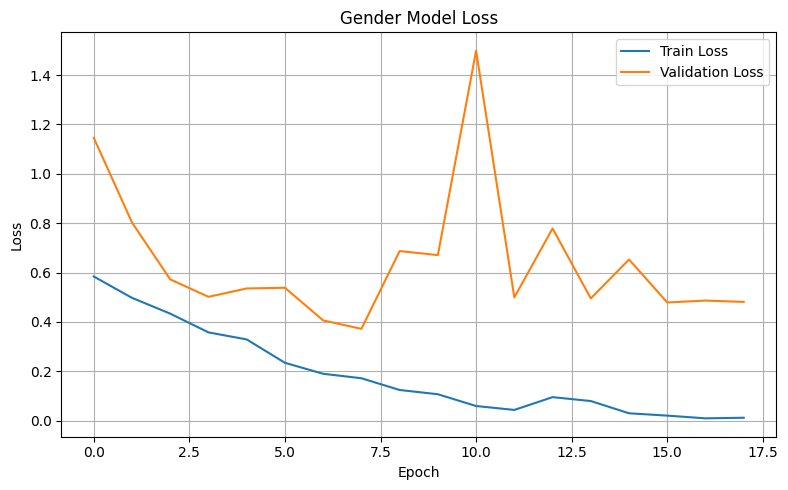

In [132]:
plot_training_history(history_gender, title="Gender Model Loss")

Gender Classification — Accuracy: 0.8800 | ROC AUC: 0.9254


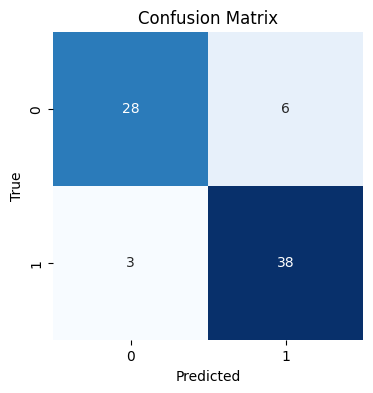

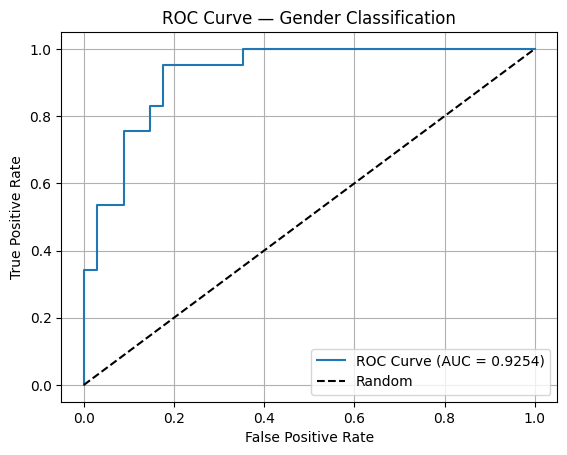

In [133]:
evaluate_gender_model(model_gender, dataloaders_baseline['val'], device)

## **Landmark Regressor**

In [134]:
num_epochs = 300
save_path = "landmark_baseline.pth"

model_landmark = LandmarkRegressor().to(device)

if os.path.exists(save_path):
    print(f"Resuming from checkpoint: {save_path}")
    model_landmark.load_state_dict(torch.load(save_path, map_location=device))
else:
    print("No checkpoint found. Starting from scratch.")

loss_fn_lmk = nn.MSELoss()
optimizer = optim.Adam(model_landmark.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

Resuming from checkpoint: landmark_baseline.pth


In [135]:
model_landmark, history_landmark = train_model(
    model=model_landmark,
    dataloaders=dataloaders_baseline,
    task_type='landmark',
    loss_fn_lmk=loss_fn_lmk,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    device=device,
    save_path=save_path,
    early_stopping_patience=10,
    verbose=True
)


Epoch 1/300
Current LR(s): 0.001000
Train Loss: 11.6407 | Val Loss: 75.1062
Model improved — saved.

Epoch 2/300
Current LR(s): 0.001000
Train Loss: 8.7242 | Val Loss: 12.2736
Model improved — saved.

Epoch 3/300
Current LR(s): 0.001000
Train Loss: 7.2172 | Val Loss: 11.8047
Model improved — saved.

Epoch 4/300
Current LR(s): 0.001000
Train Loss: 5.7490 | Val Loss: 13.5412

Epoch 5/300
Current LR(s): 0.001000
Train Loss: 4.9897 | Val Loss: 10.9471
Model improved — saved.

Epoch 6/300
Current LR(s): 0.001000
Train Loss: 4.6486 | Val Loss: 7.6984
Model improved — saved.

Epoch 7/300
Current LR(s): 0.001000
Train Loss: 4.2472 | Val Loss: 12.7910

Epoch 8/300
Current LR(s): 0.001000
Train Loss: 3.4351 | Val Loss: 7.1480
Model improved — saved.

Epoch 9/300
Current LR(s): 0.001000
Train Loss: 3.1657 | Val Loss: 8.6566

Epoch 10/300
Current LR(s): 0.001000
Train Loss: 2.7496 | Val Loss: 5.9127
Model improved — saved.

Epoch 11/300
Current LR(s): 0.001000
Train Loss: 2.4959 | Val Loss: 5.618

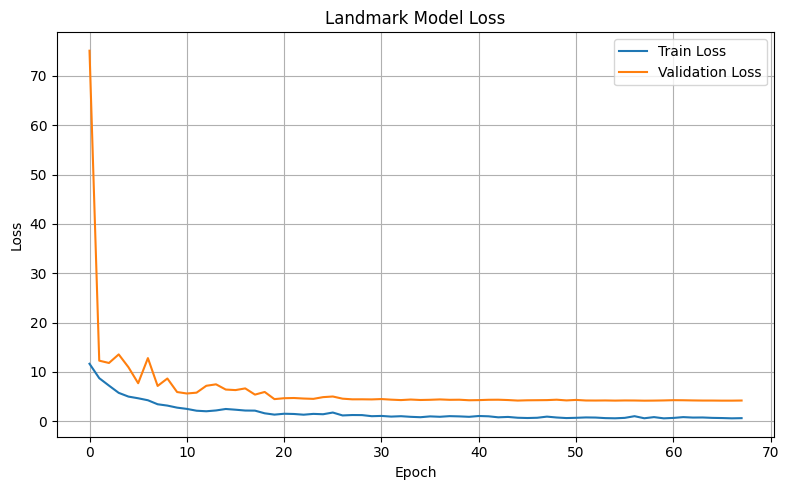

In [136]:
plot_training_history(history_landmark, title="Landmark Model Loss")

Landmark Detection — MSE: 4.8069 | NME: 0.0103


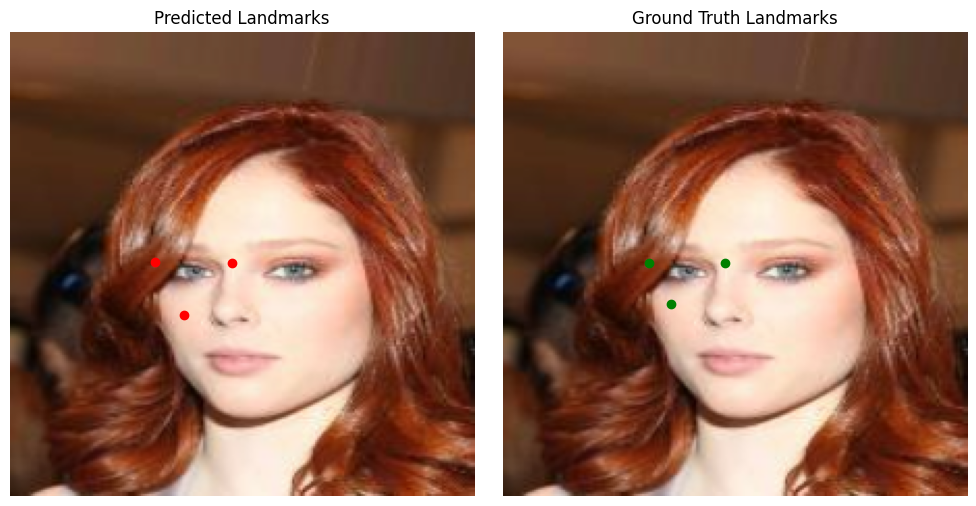

In [137]:
evaluate_landmark_model(model_landmark, dataloaders_baseline['val'], device)

## **Multi-Task Model: Baseline**

In [138]:
num_epochs = 300
save_path = "multitask_baseline.pth"

model_multitask = MultiTaskModel().to(device)

if os.path.exists(save_path):
    print(f"Resuming MultiTaskModel from: {save_path}")
    model_multitask.load_state_dict(torch.load(save_path, map_location=device))
else:
    print("No saved weights for MultiTaskModel. Training from scratch.")

loss_fn_cls = nn.BCEWithLogitsLoss()
loss_fn_lmk = nn.MSELoss()

optimizer = optim.Adam(model_multitask.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

loss_weights = {'cls': 1.0, 'lmk': 1.0}

No saved weights for MultiTaskModel. Training from scratch.


In [139]:
model_multitask, history_multitask = train_model(
    model=model_multitask,
    dataloaders=dataloaders_baseline,
    task_type='multitask',
    loss_fn_cls=(loss_fn_cls, loss_fn_lmk),
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    device=device,
    loss_weights=loss_weights,
    save_path=save_path,
    early_stopping_patience=10,
    verbose=True
)


Epoch 1/300
Current LR(s): 0.001000
Train Loss: 10485.0183 | Val Loss: 9148.3545
Model improved — saved.

Epoch 2/300
Current LR(s): 0.001000
Train Loss: 9022.9059 | Val Loss: 8191.6216
Model improved — saved.

Epoch 3/300
Current LR(s): 0.001000
Train Loss: 7490.0230 | Val Loss: 6649.4854
Model improved — saved.

Epoch 4/300
Current LR(s): 0.001000
Train Loss: 5925.8940 | Val Loss: 5122.2288
Model improved — saved.

Epoch 5/300
Current LR(s): 0.001000
Train Loss: 4493.7814 | Val Loss: 3814.5831
Model improved — saved.

Epoch 6/300
Current LR(s): 0.001000
Train Loss: 3271.5844 | Val Loss: 2706.8999
Model improved — saved.

Epoch 7/300
Current LR(s): 0.001000
Train Loss: 2273.0571 | Val Loss: 1740.1349
Model improved — saved.

Epoch 8/300
Current LR(s): 0.001000
Train Loss: 1529.2923 | Val Loss: 1232.2791
Model improved — saved.

Epoch 9/300
Current LR(s): 0.001000
Train Loss: 977.8707 | Val Loss: 825.6411
Model improved — saved.

Epoch 10/300
Current LR(s): 0.001000
Train Loss: 612.12

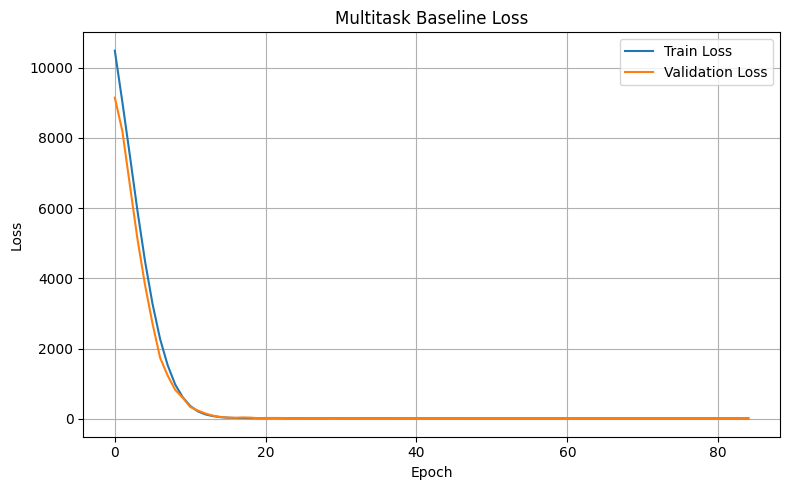

In [140]:
plot_training_history(history_multitask, title="Multitask Baseline Loss")

[GENDER] Accuracy: 0.6000 | ROC AUC: 0.6858


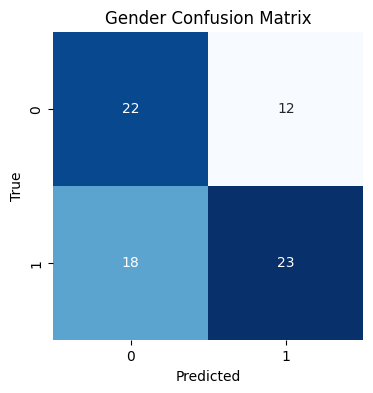

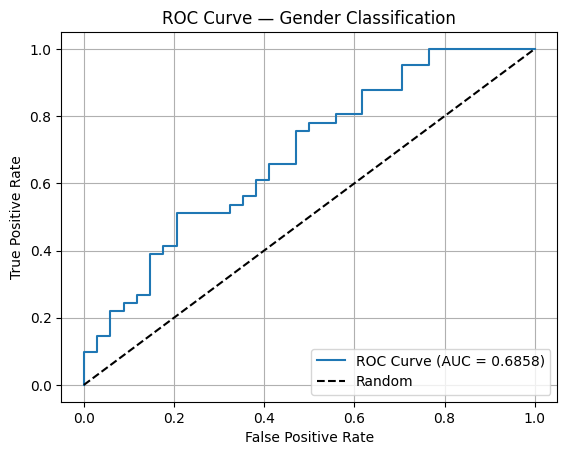

[LANDMARK] MSE: 10.0800 | NME: 0.0142


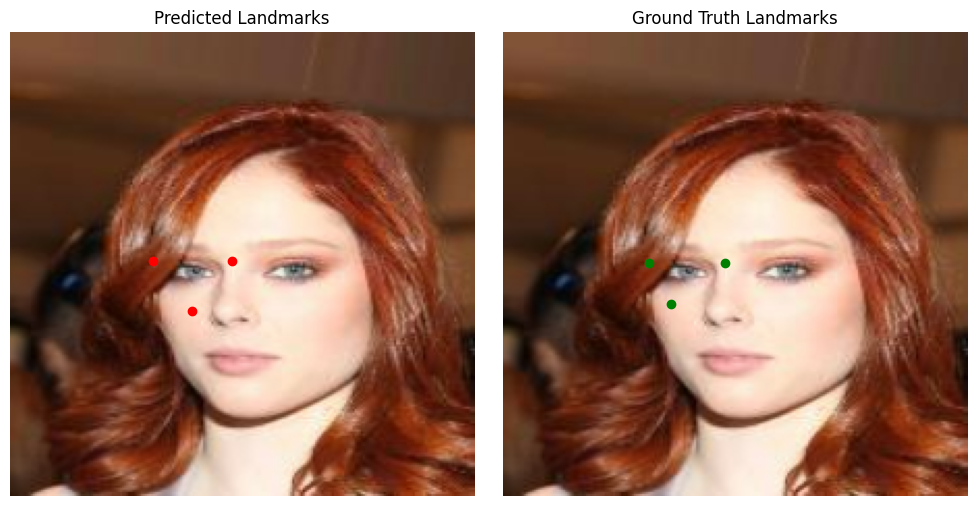

In [141]:
evaluate_multitask_model(model_multitask, dataloaders_baseline['val'], device)

## **Multi-Task Model: Improved Version**

In [150]:
save_path = "multitask_improved.pth"
num_epochs = 300

model_multitask_imp = MultiTaskModelImproved().to(device)

if os.path.exists(save_path):
    print(f"Resuming MultiTaskModel (Improved) from: {save_path}")
    model_multitask_imp.load_state_dict(torch.load(save_path, map_location=device))
else:
    print("No saved weights for MultiTaskModel (Improved). Training from scratch.")

loss_fn_cls = nn.BCEWithLogitsLoss()
loss_fn_lmk = WingLoss(w=10, epsilon=2)

optimizer = optim.AdamW(model_multitask_imp.parameters(), lr=1e-3, weight_decay=1e-4)

steps_per_epoch = len(dataloaders_improved['train'])
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    anneal_strategy='cos',
    pct_start=0.3
)

loss_weights = {'cls': 1.0, 'lmk': 1.0}

No saved weights for MultiTaskModel (Improved). Training from scratch.


In [151]:
model_multitask_imp, history_improved = train_model(
    model=model_multitask_imp,
    dataloaders=dataloaders_improved,
    task_type='multitask',
    loss_fn_cls=(loss_fn_cls, loss_fn_lmk),
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    device=device,
    loss_weights=loss_weights,
    save_path=save_path,
    early_stopping_patience=12,
    verbose=True,
    improved_multitask=True
)


Epoch 1/300
Current LR(s): 0.000040
Train Loss: 112.1153 | Val Loss: 111.5556
Model improved — saved.

Epoch 2/300
Current LR(s): 0.000040
Train Loss: 111.5812 | Val Loss: 111.1122
Model improved — saved.

Epoch 3/300
Current LR(s): 0.000041
Train Loss: 111.2420 | Val Loss: 110.7493
Model improved — saved.

Epoch 4/300
Current LR(s): 0.000043
Train Loss: 110.9348 | Val Loss: 110.4299
Model improved — saved.

Epoch 5/300
Current LR(s): 0.000045
Train Loss: 110.6355 | Val Loss: 110.0913
Model improved — saved.

Epoch 6/300
Current LR(s): 0.000047
Train Loss: 110.3041 | Val Loss: 109.7050
Model improved — saved.

Epoch 7/300
Current LR(s): 0.000051
Train Loss: 109.9539 | Val Loss: 109.2830
Model improved — saved.

Epoch 8/300
Current LR(s): 0.000054
Train Loss: 109.5691 | Val Loss: 108.8099
Model improved — saved.

Epoch 9/300
Current LR(s): 0.000059
Train Loss: 109.1442 | Val Loss: 108.3123
Model improved — saved.

Epoch 10/300
Current LR(s): 0.000064
Train Loss: 108.6777 | Val Loss: 10

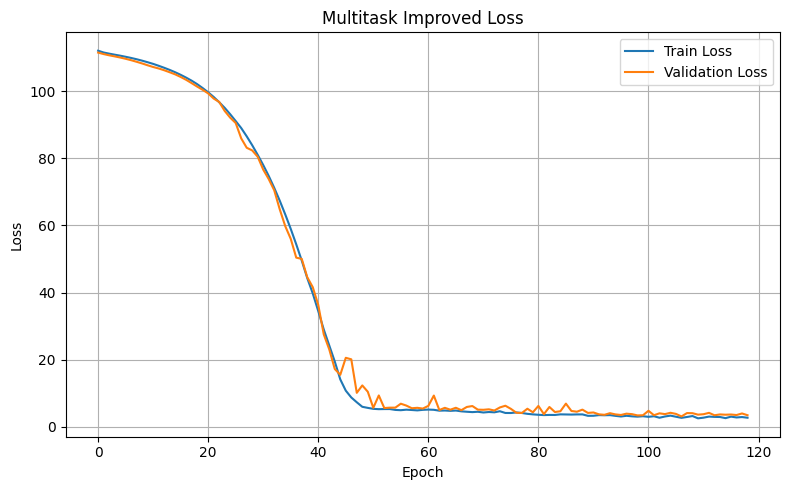

In [152]:
plot_training_history(history_improved, title="Multitask Improved Loss")

[GENDER] Accuracy: 0.9200 | ROC AUC: 0.9892


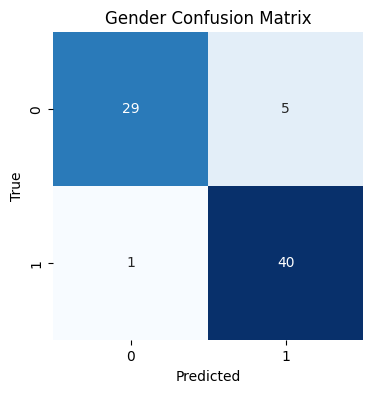

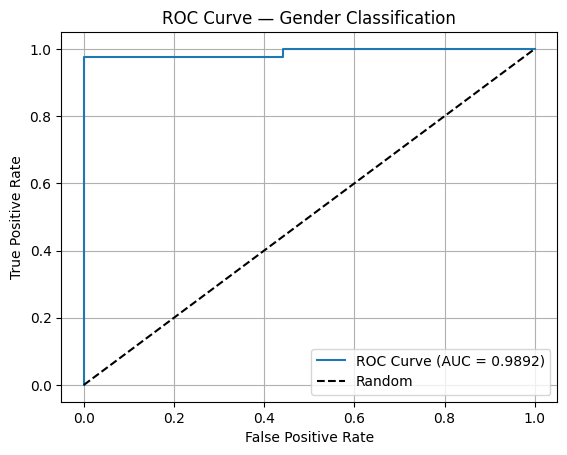

[LANDMARK] MSE: 1.3993 | NME: 0.0055


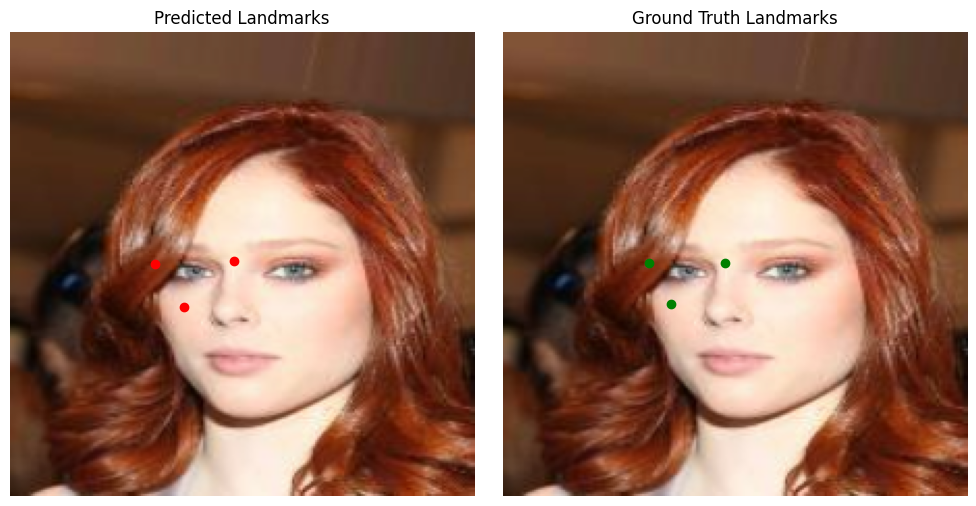

In [153]:
evaluate_multitask_model(model_multitask_imp, dataloaders_improved['val'], device)